In [1]:
### this is for running in local ###
import os
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from torchinfo import summary
import transformer

proxy_exported


### Loading Data 

In [3]:
# settings
batch_size = 16
num_workers = 2
IMG_SIZE = 224
height = 224
width = 224
color_channels = 3
patch_size = 16
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Dataloader for the data
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])
train_dir = 'pizza_steak_sushi/train'
test_dir = 'pizza_steak_sushi/test'
train_data = datasets.ImageFolder(train_dir,transform = manual_transform)
test_data = datasets.ImageFolder(test_dir,transform = manual_transform)
class_names = train_data.classes
train_dataloader = DataLoader(train_data,batch_size = batch_size,
                              shuffle=True,num_workers=num_workers,
                              pin_memory=True)
test_dataloader = DataLoader(test_data,batch_size = batch_size,
                              shuffle=False,num_workers=num_workers,
                              pin_memory=True)

(-0.5, 223.5, 223.5, -0.5)

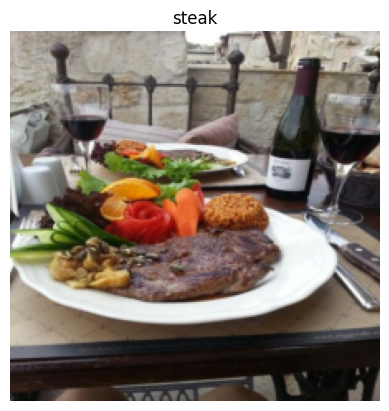

In [5]:
# sample image
img_batch, label_batch = next(iter(train_dataloader))

image, label = img_batch[0], label_batch[0]
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

### Defining the model and optimizer 

In [6]:
vit_model = transformer.ViT(num_classes = 3)
vit_model.to(device)
optimizer = torch.optim.Adam(params = vit_model.parameters(),lr=3e-3,betas=(0.9,0.999),
                             weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

summary(model= vit_model, input_size=(32,3,224,224), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### Training the Model 

In [7]:
for epoch in tqdm(range(epochs)):
    vit_model.train()
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(train_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = vit_model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    
    

    train_loss = train_loss / len(train_dataloader)
    train_acc  = train_acc / len(train_dataloader)
    vit_model.eval()
    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            X,y = X.to(device), y.to(device)
            y_pred = vit_model(X)

            loss = loss_fn(y_pred,y)
            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim = 1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)
      

    test_loss = train_loss / len(train_dataloader)
    test_acc  = train_acc / len(train_dataloader)


    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9614 | train_acc: 0.3667 | test_loss: 0.1974 | test_acc: 0.0244
Epoch: 2 | train_loss: 1.4704 | train_acc: 0.4292 | test_loss: 0.0980 | test_acc: 0.0286
Epoch: 3 | train_loss: 1.3150 | train_acc: 0.3083 | test_loss: 0.0877 | test_acc: 0.0206
Epoch: 4 | train_loss: 1.1695 | train_acc: 0.3042 | test_loss: 0.0780 | test_acc: 0.0203
Epoch: 5 | train_loss: 1.2194 | train_acc: 0.3000 | test_loss: 0.0813 | test_acc: 0.0200
Epoch: 6 | train_loss: 1.1601 | train_acc: 0.3125 | test_loss: 0.0773 | test_acc: 0.0208
Epoch: 7 | train_loss: 1.1665 | train_acc: 0.3083 | test_loss: 0.0778 | test_acc: 0.0206
Epoch: 8 | train_loss: 1.2435 | train_acc: 0.3333 | test_loss: 0.0829 | test_acc: 0.0222
Epoch: 9 | train_loss: 1.1486 | train_acc: 0.3167 | test_loss: 0.0766 | test_acc: 0.0211
Epoch: 10 | train_loss: 1.1134 | train_acc: 0.3792 | test_loss: 0.0742 | test_acc: 0.0253
